
# Win Prediction — Transformer (MoE, 2025-style) + Calibration + Explicabilité complète

Objectif : un pipeline **robuste et explicable** pour prédire la win (`R∈{-1,1}` → {0,1}), en tirant parti d'un **Transformer tabulaire séquentiel** avec **Mixture-of-Experts (Top-2)**, **calibration** (Platt), et un panel clair d'explications : **Integrated Gradients (global/local)**, **SHAP Kernel** (global), **LIME** (local), **PDP/ICE**, **attentions**.  
On trace aussi : courbes d'apprentissage, calibration, *backtest* temporel, **prédictions historiques vs réelles**, et **20 scénarios futurs** exportés.

> Conçu pour tourner en CPU ; décommentez les installations si nécessaire.


## (Optionnel) Installations

In [474]:

# %pip install -q pandas numpy scikit-learn matplotlib torch shap lime


## Imports & configuration

In [475]:

import os, math, json, random, warnings, time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss, brier_score_loss, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve

import torch
import torch.nn as nn
import torch.nn.functional as _F
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings("ignore")
np.random.seed(42); random.seed(42); torch.manual_seed(42)
DEVICE = torch.device("cpu")
print("Torch device:", DEVICE)


Torch device: cpu


## Chargement des données (Google Sheet + fallback CSV)

In [476]:

SHEET_ID = "1PdnadzZswADLqGBrI53a_8IsegivCMSz1pCZOh384-Y"
GID = "1517184233"
DATA_PATH = f"https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=csv&gid={GID}"
FALLBACK = "TEAM DIFF  @10 MIN - New.csv"  # placez ce fichier à côté du notebook si besoin
print(DATA_PATH)
def load_df():
    try:
        df = pd.read_csv(DATA_PATH).dropna(axis=1, how="all")
        print("Loaded from Google Sheet")
        return df
    except Exception as e:
        print("Google Sheet failed, fallback:", e)
        if os.path.exists(FALLBACK):
            return pd.read_csv(FALLBACK)
        raise

df = load_df().replace({"-": np.nan})
print("Shape raw:", df.shape)


https://docs.google.com/spreadsheets/d/1PdnadzZswADLqGBrI53a_8IsegivCMSz1pCZOh384-Y/export?format=csv&gid=1517184233
Loaded from Google Sheet
Shape raw: (107, 8)


## Feature engineering cohérent avec ton cadre

In [477]:

CANDS = {
    "label": ["R","result","win","label","target"],
    "gap": ["Team Gap Early","team gap early","team_diff","team_gap","teamgap"],
    "rel": ["Perf relative","relative_perf","rel_perf","perf_relative","relative"],
    "intr": ["Perf intrinsèque","intrinsic_perf","intrinsic_skill","perf_intrinseque","intrinsic"],
    "time": ["timestamp","time","date","match_time"]
}

def pick_name(df, keys):
    cols = list(df.columns)
    for k in keys:
        for c in cols:
            if c.lower().strip()==k.lower().strip(): return c
    for k in keys:
        for c in cols:
            if k.lower().strip() in c.lower().strip(): return c
    return None

label_col = pick_name(df, CANDS["label"])
gap_col   = pick_name(df, CANDS["gap"])
rel_col   = pick_name(df, CANDS["rel"])
intr_col  = pick_name(df, CANDS["intr"])
time_col  = pick_name(df, CANDS["time"])

assert label_col and gap_col, "R et Team Gap Early requis"
for c in [label_col, gap_col, rel_col, intr_col]:
    if c and c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Label {-1,1} -> {0,1}
df = df.dropna(subset=[label_col, gap_col]).copy()
df[label_col] = df[label_col].map({-1:0, 1:1}).fillna(df[label_col]).astype(int)
# Gap borné
df[gap_col] = df[gap_col].clip(-2,2).fillna(0.0)

# Perf relative
if rel_col is None:
    rel_col = "Perf relative (fallback)"
    df[rel_col] = 0.0
else:
    df[rel_col] = df[rel_col].fillna(0.0)

# Perf intrinsèque (fallback EMA relative)
if intr_col and intr_col in df.columns:
    df["intrinsic_skill"] = pd.to_numeric(df[intr_col], errors="coerce").fillna(0.0)
else:
    s = df[rel_col].fillna(0.0)
    df["intrinsic_skill"] = s.ewm(alpha=0.2, adjust=False).mean().shift(1).fillna(s.median())

# Lose streak sur gap négatif
streak=0; ls=[]
for g in df[gap_col].values:
    if g<0: streak+=1
    else: streak=0
    ls.append(streak)
df["lose_streak"] = ls

# Interactions
df["gap_x_rel"] = df[gap_col]*df[rel_col]
df["rel_sq"] = df[rel_col]**2
df["skill_sq"] = df["intrinsic_skill"]**2

FEATURES_BASE = [gap_col, rel_col, "intrinsic_skill", "lose_streak", "gap_x_rel", "rel_sq", "skill_sq"]
print("Features:", FEATURES_BASE)

def coerce_numeric_series(s: pd.Series) -> pd.Series:
    """Transforme une série potentiellement texte -> float32 propre.
       - remplace ',' par '.'
       - extrait le 1er nombre (ignore le reste du texte)
       - to_numeric
       - winsorize léger (1–99%) pour éviter les énormes valeurs accidentelles
       - ffill/bfill -> médiane -> 0.0
    """
    s = s.astype(str).str.replace(",", ".", regex=False)
    s = s.str.extract(r"([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)", expand=False)
    s = pd.to_numeric(s, errors="coerce").replace([np.inf, -np.inf], np.nan)

    if s.notna().sum() > 0:
        lo = np.nanpercentile(s, 1)
        hi = np.nanpercentile(s, 99)
        s = s.clip(lo, hi)

    s = s.ffill().bfill()
    if s.isna().any():
        med = float(np.nanmedian(s.values)) if np.isfinite(np.nanmedian(s.values)) else 0.0
        s = s.fillna(med)
    return s.astype(np.float32)

def clean_numeric(df: pd.DataFrame, cols):
    df = df.copy()
    for c in cols:
        df[c] = coerce_numeric_series(df[c])
    return df

# applique sur nos features (et seulement elles)
df = clean_numeric(df, FEATURES_BASE)

# (re)construit les dérivées au cas où
df["gap_x_rel"] = df[gap_col] * df[rel_col]
df["rel_sq"]    = df[rel_col]**2
df["skill_sq"]  = df["intrinsic_skill"]**2

# garde-fous
Xcheck = df[FEATURES_BASE].values
assert np.isfinite(Xcheck).all(), "Encore des non-finies après nettoyage."


df.head(1000)


Features: ['Team Gap Early', 'Perf relative', 'intrinsic_skill', 'lose_streak', 'gap_x_rel', 'rel_sq', 'skill_sq']


,% / Rela,% / Intra,Pred_TeamGapEarly_Next,Team Gap Early,R,Perf relative,Perf intrinsèque,Unnamed: 9,intrinsic_skill,lose_streak,gap_x_rel,rel_sq,skill_sq
0,NaN,NaN,NaN,0.0,1,-2.0,0.0,NaN,0.0,0.0,-0.0,4.0,0.0
1,NaN,NaN,NaN,-1.0,0,-2.0,0.0,NaN,0.0,1.0,2.0,4.0,0.0
2,NaN,NaN,NaN,2.0,1,-1.0,2.0,NaN,2.0,0.0,-2.0,1.0,4.0
3,NaN,NaN,NaN,-1.0,1,-1.0,0.0,NaN,0.0,1.0,1.0,1.0,0.0
4,NaN,NaN,NaN,-1.0,0,2.0,0.0,- Un mec run down : \nGarder son calme et joue...,0.0,2.0,-2.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,63,60,NaN,0.0,1,-1.0,0.0,NaN,0.0,0.0,-0.0,1.0,0.0
59,50,56,NaN,1.0,1,1.0,2.0,NaN,2.0,0.0,1.0,1.0,4.0
60,51,61,"28,66690063",-2.0,0,-2.0,-1.0,NaN,-1.0,1.0,4.0,4.0,1.0
61,47,60,"26,82653704",-2.0,0,-2.0,-2.0,NaN,-2.0,2.0,4.0,4.0,4.0


## Construction séquentielle (fenêtrage)

In [478]:
# === Séquençage robuste + split temporel par index-cible + scaling 3D robuste ===
from sklearn.preprocessing import StandardScaler
import numpy as np

WIN = 5
FEATS = FEATURES_BASE
F = len(FEATS)

# 1) construire TOUTES les séquences d'abord
vals = df[FEATS].values.astype(np.float32)
labs = df[label_col].values.astype(np.int64)
N_raw = len(df)

X_all, y_all, t_idx = [], [], []
for i in range(WIN, N_raw):
    X_all.append(vals[i-WIN:i, :])         # (WIN,F)
    y_all.append(labs[i])                  # 0/1
    t_idx.append(i)                        # index absolu de la cible

if len(X_all) == 0:
    raise ValueError(f"Aucune séquence. Augmente les données ou baisse WIN (actuel={WIN}).")

X_all = np.stack(X_all, axis=0).astype(np.float32)  # (N_seq,WIN,F)
y_all = np.asarray(y_all, dtype=np.int64)
t_idx = np.asarray(t_idx, dtype=int)

# 2) split chrono par l'index de la cible
cut  = int(0.70 * N_raw)
cut2 = int(0.85 * N_raw)
m_tr = t_idx < cut
m_va = (t_idx >= cut) & (t_idx < cut2)
m_te = t_idx >= cut2

Xtr, ytr = X_all[m_tr], y_all[m_tr]
Xva, yva = X_all[m_va], y_all[m_va]
Xte, yte = X_all[m_te], y_all[m_te]

print("Seq shapes (avant scaling):", Xtr.shape, Xva.shape, Xte.shape)

# 3) si val/test vides, on prélève au bout du train pour éviter tout crash
def siphon_from_train(Xtr, ytr, take_ratio=0.15, min_take=1):
    if len(Xtr) <= 1: 
        return Xtr, ytr, Xtr[:0], ytr[:0]
    take = max(min_take, int(take_ratio * len(Xtr)))
    take = min(take, len(Xtr)-1)
    return (Xtr[:-take], ytr[:-take], Xtr[-take:], ytr[-take:])

if Xva.shape[0] == 0 and Xtr.shape[0] >= 2:
    Xtr, ytr, Xva, yva = siphon_from_train(Xtr, ytr, take_ratio=0.15)
    print(f"Val vide → prélèvement {len(Xva)} séq depuis la fin du train.")
if Xte.shape[0] == 0 and Xtr.shape[0] >= 2:
    Xtr, ytr, Xte, yte = siphon_from_train(Xtr, ytr, take_ratio=0.15)
    print(f"Test vide → prélèvement {len(Xte)} séq depuis la fin du train.")

# 4) scaling 3D : fit sur (N_train*T,1) par feature, transform idem
scalers = []
for j in range(F):
    sc = StandardScaler()
    sc.fit(Xtr[:, :, j].reshape(-1, 1))
    scalers.append(sc)

def transform3d(X, scalers):
    if X.ndim != 3 or X.shape[0] == 0:
        return X
    N, T, F_ = X.shape
    Z = X.copy()
    for j, sc in enumerate(scalers):
        col = Z[:, :, j].reshape(-1, 1)
        col = sc.transform(col)
        col = np.nan_to_num(col, nan=0.0, posinf=0.0, neginf=0.0)
        Z[:, :, j] = col.reshape(N, T)
    if not np.isfinite(Z).all():
        raise ValueError("Après scaling: valeurs non finies détectées.")
    return Z



Xtrn = transform3d(Xtr, scalers)
Xvan = transform3d(Xva, scalers)
Xten = transform3d(Xte, scalers)

def assert_finite(name, X):
    if not np.isfinite(X).all():
        bad = ~np.isfinite(X)
        feat_bad = bad.reshape(-1, X.shape[-1]).any(axis=0)
        bad_feats = [f for f, m in zip(FEATS, feat_bad) if m]
        raise ValueError(f"{name} contient des non-finies sur features: {bad_feats}")

assert_finite("Xtrn", Xtr) ; assert_finite("Xva", Xva) ; assert_finite("Xte", Xte)


print("Seq shapes (après scaling):", Xtrn.shape, Xvan.shape, Xten.shape, "| y_train mean:", ytr.mean() if ytr.size else "NA")


Seq shapes (avant scaling): (39, 5, 7) (9, 5, 7) (10, 5, 7)
Seq shapes (après scaling): (39, 5, 7) (9, 5, 7) (10, 5, 7) | y_train mean: 0.5128205128205128


## Modèle Transformer Tabulaire séquentiel + MoE (Top-2)

In [479]:
class ExpertMLP(nn.Module):
    def __init__(self, d, h):
        super().__init__()
        self.fc1 = nn.Linear(d, h)
        self.fc2 = nn.Linear(h, d)
    def forward(self, x):
        return self.fc2(_F.silu(self.fc1(x)))

class Top1GumbelMoE(nn.Module):
    """
    Routing Top-1 façon Switch avec Gumbel-Softmax + straight-through.
    IMPORTANT: on pondère la somme des sorties des experts par w_st (one-hot ST)
    => gradients vers la gate + vers TOUS les experts (pas seulement l’expert choisi).
    """
    def __init__(self, d_model, n_experts=4, hidden=64, tau_start=2.0, tau_end=0.5, anneal_epochs=200):
        super().__init__()
        self.experts = nn.ModuleList([ExpertMLP(d_model, hidden) for _ in range(n_experts)])
        self.gate = nn.Linear(d_model, n_experts)
        self.n_experts = n_experts
        self.tau_start, self.tau_end = tau_start, tau_end
        self.anneal_epochs = float(anneal_epochs)
        self.register_buffer("t", torch.tensor(0.))  # compteur d’epochs (incrémenté dans la loop)

    def temperature(self):
        p = torch.clamp(self.t / max(1.0, self.anneal_epochs), 0, 1)
        return self.tau_start*(1-p) + self.tau_end*p
    
    def forward(self, x):
        logits = self.gate(x)
        tau = max(self.temperature(), 1e-3)
        u = torch.rand_like(logits).clamp_(1e-6, 1 - 1e-6)
        gumbel = -torch.log(-torch.log(u))
        w_soft = _F.softmax((logits + gumbel) / tau, dim=-1)
        hard_idx = w_soft.argmax(dim=-1)
        one_hot = _F.one_hot(hard_idx, num_classes=self.n_experts).float()
        w_st = one_hot - w_soft.detach() + w_soft

        Ys = torch.stack([exp(x) for exp in self.experts], dim=-2)  # [B,T,E,D]
        out = (w_st.unsqueeze(-1) * Ys).sum(dim=-2)
        out = torch.nan_to_num(out, nan=0.0, posinf=0.0, neginf=0.0)
        aux = w_soft.mean(dim=(0,1))
        return out, aux

class BlockGumbel(nn.Module):
    def __init__(self, d_model, nhead, n_experts=4, moe_hidden=64, p=0.1, p_attn=0.0):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, nhead, batch_first=True, dropout=p_attn)
        self.ln1 = nn.LayerNorm(d_model)
        self.moe = Top1GumbelMoE(d_model, n_experts=n_experts, hidden=moe_hidden)
        self.ln2 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(p)
    def forward(self, x, attn_mask=None):
        h, w = self.attn(x, x, x, attn_mask=attn_mask, need_weights=True, average_attn_weights=False)
        x = self.ln1(x + self.drop(h))
        y, aux = self.moe(x)
        x = self.ln2(x + self.drop(y))
        return x, w, aux
    
def _init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

class TabTransformerMoE(nn.Module):
    def __init__(self, d_in, d_model=64, depth=3, nhead=4, n_experts=4, moe_hidden=64, p=0.1, p_attn=0.0):
        super().__init__()
        self.proj = nn.Linear(d_in, d_model)
        self.blocks = nn.ModuleList([BlockGumbel(d_model, nhead, n_experts, moe_hidden, p, p_attn)
                                     for _ in range(depth)])
        self.head = nn.Linear(d_model, 1)
        self.apply(_init_weights)
    def forward(self, x):
        z = self.proj(x)
        attn_ws, auxs = [], []
        for blk in self.blocks:
            z, w, aux = blk(z, attn_mask=None)
            attn_ws.append(w); auxs.append(aux)
        logit = self.head(z.mean(dim=1)).squeeze(-1)
        return logit, attn_ws, auxs


## Entraînement : AdamW + early stopping (logloss) + OneCycleLR

Xtrn/Xvan: (39, 5, 7) (9, 5, 7) | y: (39,) (9,)
[init] val_logloss=0.9834 (n=9) | steps/epoch=3
[ep 001] train=0.8608  val=0.7744  (batches=4)
[ep 005] train=1.2763  val=3.0948  (batches=4)
[ep 010] train=1.0962  val=1.2816  (batches=4)
[ep 015] train=0.7902  val=1.5018  (batches=4)
[ep 020] train=0.7463  val=0.9185  (batches=4)
[ep 025] train=0.6963  val=0.6624  (batches=4)
[ep 030] train=0.6520  val=0.7054  (batches=4)
[ep 035] train=0.6999  val=0.7797  (batches=4)
[ep 040] train=0.7001  val=0.6890  (batches=4)
[ep 045] train=0.6831  val=0.6915  (batches=4)
[ep 050] train=0.7172  val=0.6450  (batches=4)
[ep 055] train=0.6892  val=0.6520  (batches=4)
[ep 060] train=0.6882  val=0.7449  (batches=4)
[ep 065] train=0.7055  val=0.6733  (batches=4)
[ep 070] train=0.6767  val=0.7239  (batches=4)
[ep 075] train=0.6684  val=0.7032  (batches=4)
[ep 080] train=0.6876  val=0.6331  (batches=4)
[ep 085] train=0.6599  val=0.7363  (batches=4)
[ep 090] train=0.6665  val=0.6712  (batches=4)
[ep 095] tr

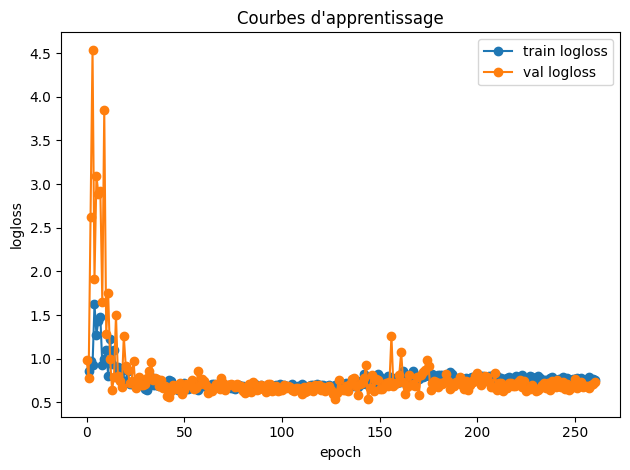

In [480]:
class SeqDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]
    
def sanitize(x):
    return torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

def train_model(
    Xtr, ytr, Xva, yva,
    epochs=120, bs=128, lr=2e-3, wd=1e-3, patience=20,
    d_model=128, depth=3, nhead=8, n_experts=8, moe_hidden=256, p=0.25, p_attn=0.15,
    mixup_alpha=0.3, time_mask_prob=0.6, time_mask_frac=0.25,
    lambda_aux=0.05, grad_clip=1.0,
    min_epochs=5, log_every=5
):
    # --- sanity ---
    assert Xtr.shape[0] > 0, f"Train vide: Xtr={Xtr.shape}"
    assert Xva.shape[0] > 0, f"Valid vide: Xva={Xva.shape}"

    tr_dl = DataLoader(SeqDS(Xtr,ytr), batch_size=bs, shuffle=True)
    va_dl = DataLoader(SeqDS(Xva,yva), batch_size=bs, shuffle=False)

    assert len(tr_dl) > 0, "DataLoader train vide (bs trop grand ?)"
    assert len(va_dl) > 0, "DataLoader val vide (bs trop grand ?)"

    model = TabTransformerMoE(
        d_in=Xtr.shape[-1], d_model=d_model, depth=depth, nhead=nhead,
        n_experts=n_experts, moe_hidden=moe_hidden, p=p, p_attn=p_attn
    ).to(DEVICE)

    pos_rate = float(ytr.mean()) if len(ytr) else 0.5
    bce = nn.BCEWithLogitsLoss(
        pos_weight=None if not (0.0 < pos_rate < 1.0) else
        torch.tensor([(1.0-pos_rate)/max(pos_rate,1e-6)], device=DEVICE)
    )

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    steps_per_epoch = max(1, len(tr_dl))
    if steps_per_epoch < 5:
        # Warmup linéaire 5 epochs puis cosine
        warmup_epochs = min(5, max(1, epochs // 10))
        base_lr = lr

        def lr_lambda(e):
            if e < warmup_epochs:
                return (e + 1) / warmup_epochs
            # cosine sur le reste
            progress = (e - warmup_epochs) / max(1, (epochs - warmup_epochs))
            return 0.5 * (1 + math.cos(math.pi * progress))

        sch = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
    else:
        sch = torch.optim.lr_scheduler.OneCycleLR(
            opt, max_lr=lr, steps_per_epoch=steps_per_epoch, epochs=epochs
        )



    def do_mixup(x, y):
        if mixup_alpha <= 0: return x, y
        lam = np.random.beta(mixup_alpha, mixup_alpha)
        idx = torch.randperm(x.size(0), device=x.device)
        return lam*x + (1-lam)*x[idx], lam*y + (1-lam)*y[idx]

    def time_mask(x):
        if time_mask_prob<=0 or np.random.rand()>time_mask_prob: return x
        B,T,D = x.shape
        L = max(1, int(T*time_mask_frac))
        s = np.random.randint(0, T-L+1)
        x2 = x.clone(); x2[:, s:s+L, :] = 0.0
        return x2

    def moe_balance_kl(aux_list):
        loss = 0.0
        for aux in aux_list:  # (E,)
            p = (aux / (aux.sum()+1e-9)).clamp_min(1e-9)
            u = torch.full_like(p, 1.0/len(p))
            loss = loss + torch.sum(p * (p.log() - u.log()))
        return loss / max(1,len(aux_list))

    best=float("inf"); bad=0; best_state=None
    hist={"train_ll":[], "val_ll":[]}

    # --- log val "epoch 0" (avant training) ---
    model.eval(); s=0.0; n=0
    with torch.no_grad():
        for xb,yb in va_dl:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE).view(-1)
            xb = sanitize(xb)
            logit, *_ = model(xb)
            loss = bce(logit, yb)
            if torch.isnan(loss):
                print("⚠️ NaN en val0 — on remplace xb NaN/Inf par 0 et on continue.")
                continue
            s += loss.item()*xb.size(0); n += xb.size(0)
    val0 = s/max(1,n)
    hist["train_ll"].append(np.nan)  # placeholder pour l'alignement visuel
    hist["val_ll"].append(val0)
    print(f"[init] val_logloss={val0:.4f} (n={n}) | steps/epoch={steps_per_epoch}")

    for ep in range(1, epochs+1):
        # anneal du Gumbel: 1 tick/epoch
        for blk in model.blocks:
            blk.moe.t += 1

        model.train(); s=0.0; n=0
        for xb,yb in tr_dl:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE).view(-1)
            xb = time_mask(xb)
            xb, yb = do_mixup(xb, yb)
            xb = sanitize(xb)
            logit, _, auxs = model(xb)
            loss = bce(logit, yb) + lambda_aux * moe_balance_kl(auxs)

            if torch.isnan(loss):
                print("⚠️ Train loss NaN — on saute ce batch.")
                continue

            opt.zero_grad(); loss.backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            opt.step(); sch.step()

            s += loss.item()*xb.size(0); n += xb.size(0)

        train_ll = s/max(1,n)  # évite division par 0 si batchs sautés
        if n == 0:
            print(f"⚠️ aucun batch effectif à l’epoch {ep} (n=0). Vérifie bs/données.")
        model.eval(); s=0.0; nv=0
        with torch.no_grad():
            for xb,yb in va_dl:
                xb = xb.to(DEVICE); yb = yb.to(DEVICE).view(-1)
                xb = sanitize(xb)
                logit, *_ = model(xb)
                l = bce(logit, yb)
                if not torch.isnan(l):
                    s += l.item()*xb.size(0); nv += xb.size(0)
        val_ll = s/max(1,nv)

        hist["train_ll"].append(train_ll)
        hist["val_ll"].append(val_ll)

        if ep % log_every == 0 or ep == 1:
            print(f"[ep {ep:03d}] train={train_ll:.4f}  val={val_ll:.4f}  (batches={n//max(1, xb.size(0)) if n>0 else 0})")

        improved = (val_ll < best - 1e-5) and np.isfinite(val_ll)
        if improved:
            best, bad = val_ll, 0
            best_state = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
        else:
            bad += 1

        if (ep >= min_epochs) and (bad >= patience):
            print(f"Early stop @ {ep} (best val={best:.4f})")
            break

    if best_state is not None:
        model.load_state_dict(best_state)
    model.eval()
    return model, hist

def auto_bs(n_train):
    return max(8, min(32, n_train // 3)) 

BIG_SWEEP = [
  # === Existantes (garde-les si tu les utilises) ===
  dict(name="DEBUG_SAFE",
       d_model=64,  depth=2, nhead=4,  n_experts=4,  moe_hidden=128,
       p=0.10, p_attn=0.00, wd=5e-4, lr=1e-3, bs=auto_bs(len(Xtrn)),
       epochs=60, patience=10,
       mixup_alpha=0.0, time_mask_prob=0.0, time_mask_frac=0.0,
       lambda_aux=0.02, grad_clip=0.5),

  dict(name="ROBUST",
       d_model=128, depth=3, nhead=8,  n_experts=8,  moe_hidden=256,
       p=0.35, p_attn=0.25, wd=2e-3, lr=2e-3, bs=auto_bs(len(Xtrn)),
       epochs=160, patience=30,
       mixup_alpha=0.2, time_mask_prob=0.4, time_mask_frac=0.25,
       lambda_aux=0.08, grad_clip=0.5),

  dict(name="REGULAR",
       d_model=128, depth=3, nhead=8,  n_experts=8,  moe_hidden=256,
       p=0.25, p_attn=0.15, wd=1e-3, lr=2e-3, bs=auto_bs(len(Xtrn)),
       epochs=120, patience=20,
       mixup_alpha=0.2, time_mask_prob=0.3, time_mask_frac=0.25,
       lambda_aux=0.05, grad_clip=1.0),

  dict(name="MOE_HEAVY",
       d_model=128, depth=3, nhead=8,  n_experts=16, moe_hidden=256,
       p=0.30, p_attn=0.20, wd=1.5e-3, lr=2.5e-3, bs=auto_bs(len(Xtrn)),
       epochs=160, patience=30,
       mixup_alpha=0.2, time_mask_prob=0.4, time_mask_frac=0.30,
       lambda_aux=0.10, grad_clip=1.0),

  # === NOUVELLES, plus grosses ou spécialisées ===

  # Un cran au-dessus de REGULAR (un peu plus large/long)
  dict(name="REGULAR_PLUS",
       d_model=160, depth=3, nhead=8,  n_experts=8,  moe_hidden=288,
       p=0.25, p_attn=0.15, wd=1.2e-3, lr=2.2e-3, bs=auto_bs(len(Xtrn)),
       epochs=140, patience=25,
       mixup_alpha=0.25, time_mask_prob=0.35, time_mask_frac=0.25,
       lambda_aux=0.06, grad_clip=1.0),

  # Large raisonnable (capacité +1 bloc)
  dict(name="LARGE_PLUS",
       d_model=192, depth=4, nhead=8,  n_experts=12, moe_hidden=320,
       p=0.30, p_attn=0.20, wd=1.5e-3, lr=2.5e-3, bs=auto_bs(len(Xtrn)),
       epochs=180, patience=30,
       mixup_alpha=0.30, time_mask_prob=0.50, time_mask_frac=0.30,
       lambda_aux=0.08, grad_clip=1.0),

  # XL (gros mais encore stable)
  dict(name="XL",
       d_model=256, depth=4, nhead=8,  n_experts=12, moe_hidden=384,
       p=0.35, p_attn=0.25, wd=2e-3, lr=3e-3, bs=auto_bs(len(Xtrn)),
       epochs=200, patience=35,
       mixup_alpha=0.35, time_mask_prob=0.60, time_mask_frac=0.35,
       lambda_aux=0.10, grad_clip=1.0),

  # XL avec 16 experts (plus de spécialisation — surveille l’overfit)
  dict(name="XL_MOE16",
       d_model=256, depth=4, nhead=8,  n_experts=16, moe_hidden=384,
       p=0.35, p_attn=0.25, wd=2.5e-3, lr=3e-3, bs=auto_bs(len(Xtrn)),
       epochs=220, patience=40,
       mixup_alpha=0.35, time_mask_prob=0.60, time_mask_frac=0.35,
       lambda_aux=0.12, grad_clip=1.0),

  # Largeur > profondeur (souvent plus stable sur peu de data)
  dict(name="DEPTH2_WIDE",
       d_model=256, depth=2, nhead=8,  n_experts=12, moe_hidden=384,
       p=0.30, p_attn=0.20, wd=1.5e-3, lr=2.5e-3, bs=auto_bs(len(Xtrn)),
       epochs=140, patience=25,
       mixup_alpha=0.25, time_mask_prob=0.45, time_mask_frac=0.30,
       lambda_aux=0.08, grad_clip=1.0),

  # Attention plus “lourde” (plus de têtes, +dropout attn)
  dict(name="ATTN_HEAVY_2",
       d_model=128, depth=5, nhead=16, n_experts=4,  moe_hidden=192,
       p=0.25, p_attn=0.35, wd=1.5e-3, lr=2e-3, bs=auto_bs(len(Xtrn)),
       epochs=160, patience=30,
       mixup_alpha=0.25, time_mask_prob=0.50, time_mask_frac=0.30,
       lambda_aux=0.04, grad_clip=1.0),

  # ROBUST encore plus régularisée (si la val bouge trop)
  dict(name="ROBUST_PLUS",
       d_model=128, depth=4, nhead=8,  n_experts=8,  moe_hidden=256,
       p=0.40, p_attn=0.30, wd=2.5e-3, lr=1.6e-3, bs=auto_bs(len(Xtrn)),
       epochs=180, patience=35,
       mixup_alpha=0.20, time_mask_prob=0.50, time_mask_frac=0.30,
       lambda_aux=0.10, grad_clip=0.5),

  # XXL — très gros modèle MoE + robustesse++ (à utiliser avec précaution !)
  dict(name="XXL_MOE_HEAVY_ROBUST",
       d_model=384, depth=6, nhead=16, n_experts=8, moe_hidden=512,
       p=0.50, p_attn=0.40, wd=3e-3, lr=2e-3, bs=auto_bs(len(Xtrn)),
       epochs=260, patience=120,
       mixup_alpha=0.38, time_mask_prob=0.70, time_mask_frac=0.40,
       lambda_aux=0.16, grad_clip=0.75),
]

# Sélection pratique par nom
def run_cfg(cfg_name):
    cfg = next(c for c in BIG_SWEEP if c["name"]==cfg_name)
    kwargs = {k:v for k,v in cfg.items() if k!="name"}
    return train_model(Xtrn, ytr, Xvan, yva, **kwargs)


print("Xtrn/Xvan:", Xtrn.shape, Xvan.shape, "| y:", ytr.shape, yva.shape)
# Exemple:
model, hist = run_cfg("XXL_MOE_HEAVY_ROBUST")

@torch.no_grad()
def logits_on_np(X):
    z, *_ = model(torch.tensor(X, dtype=torch.float32).to(DEVICE))
    return z.cpu().numpy()

def sigmoid(x): return 1.0 / (1.0 + np.exp(-x))

from sklearn.metrics import roc_auc_score, average_precision_score, log_loss, brier_score_loss, accuracy_score

for name, (X, y) in {
    "Train": (Xtrn, ytr),
    "Valid": (Xvan, yva),
    "Test":  (Xten, yte),
}.items():
    z = logits_on_np(X)
    p = np.clip(sigmoid(z), 1e-6, 1-1e-6)
    ll = log_loss(y, p)
    auc = roc_auc_score(y, p) if len(np.unique(y)) > 1 else float("nan")
    ap  = average_precision_score(y, p) if len(np.unique(y)) > 1 else float("nan")
    br  = brier_score_loss(y, p)
    acc = accuracy_score(y, (p >= 0.5).astype(int))
    print(f"{name:5s}  LogLoss={ll:.3f}  AUC={auc:.3f}  AP={ap:.3f}  Brier={br:.3f}  Acc={acc:.3f}")


plt.figure()
plt.plot(hist["train_ll"], label="train logloss", marker="o")
plt.plot(hist["val_ll"],   label="val logloss",   marker="o")
plt.xlabel("epoch"); plt.ylabel("logloss"); plt.title("Courbes d'apprentissage")
plt.legend(); plt.tight_layout(); plt.show()



## Calibration (Platt) + Évaluations complètes + tracés

Platt: a=-0.5763 b=0.2880
Train  AUC=0.4316  PR=0.4677  LogLoss=0.7233  Brier=0.2637  Acc=0.5128
Valid  AUC=0.5500  PR=0.5962  LogLoss=0.7238  Brier=0.2610  Acc=0.5556
Test   AUC=0.2500  PR=0.3382  LogLoss=0.7563  Brier=0.2813  Acc=0.3000


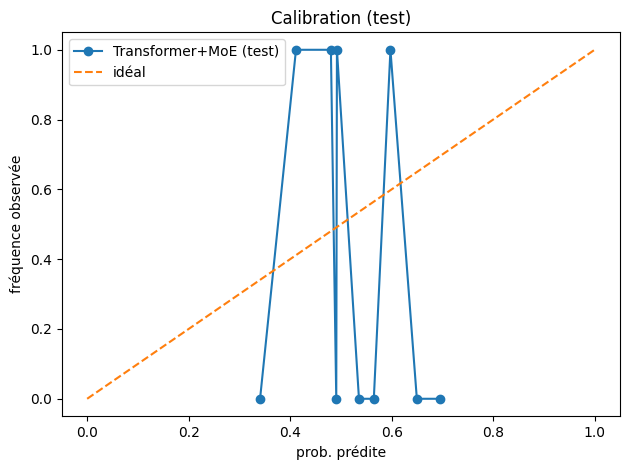

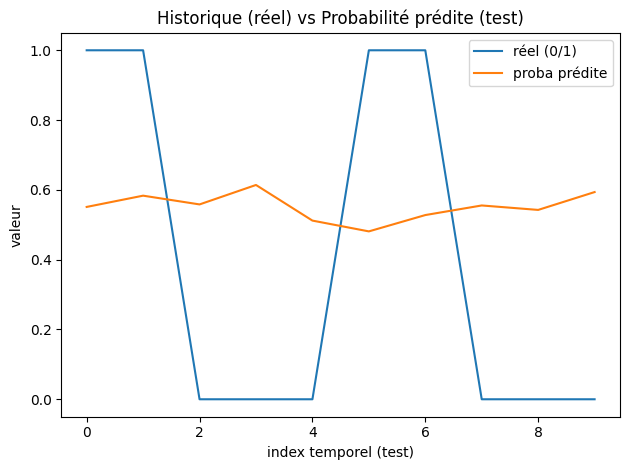

In [481]:

@torch.no_grad()
def logits_on(X):
    z,_,_ = model(torch.tensor(X, dtype=torch.float32).to(DEVICE))
    return z.cpu().numpy()

z_tr = logits_on(Xtrn); z_va = logits_on(Xvan); z_te = logits_on(Xten)

# Platt on validation
ab = torch.nn.Parameter(torch.tensor([1.0, 0.0], dtype=torch.float32))
opt = torch.optim.LBFGS([ab], lr=0.5, max_iter=200, line_search_fn="strong_wolfe")
zv = torch.tensor(z_va, dtype=torch.float32)
yv = torch.tensor(yva, dtype=torch.float32).view(-1,1)
def nll():
    opt.zero_grad()
    a,b = ab[0], ab[1]
    p = torch.sigmoid(a*zv + b).view(-1,1)
    loss = _F.binary_cross_entropy(p, yv)
    loss.backward(); return loss
opt.step(nll); a,b = ab.detach().numpy().tolist()
print("Platt: a=%.4f b=%.4f" % (a,b))

def proba(X):
    z = logits_on(X)
    p = 1/(1+np.exp(-(a*z + b)))
    return np.clip(p, 1e-6, 1-1e-6)

for name,(X,y) in {"Train":(Xtrn,ytr),"Valid":(Xvan,yva),"Test":(Xten,yte)}.items():
    p = proba(X)
    auc = roc_auc_score(y, p); pr = average_precision_score(y, p)
    ll  = log_loss(y, p); br = brier_score_loss(y, p)
    acc = accuracy_score(y, (p>=0.5).astype(int))
    print(f"{name:5s}  AUC={auc:.4f}  PR={pr:.4f}  LogLoss={ll:.4f}  Brier={br:.4f}  Acc={acc:.4f}")

# Calibration curve (test)
pt, pp = calibration_curve(yte, proba(Xten), n_bins=10, strategy="quantile")
plt.figure()
plt.plot(pp, pt, "o-", label="Transformer+MoE (test)")
plt.plot([0,1],[0,1],"--", label="idéal")
plt.xlabel("prob. prédite"); plt.ylabel("fréquence observée"); plt.title("Calibration (test)")
plt.legend(); plt.tight_layout(); plt.show()

# Historique vs proba prédite (sur test)
plt.figure()
plt.plot(range(len(yte)), yte, label="réel (0/1)")
plt.plot(range(len(yte)), proba(Xten), label="proba prédite")
plt.xlabel("index temporel (test)"); plt.ylabel("valeur")
plt.title("Historique (réel) vs Probabilité prédite (test)")
plt.legend(); plt.tight_layout(); plt.show()


## Attentions & usage des experts (diagnostic)

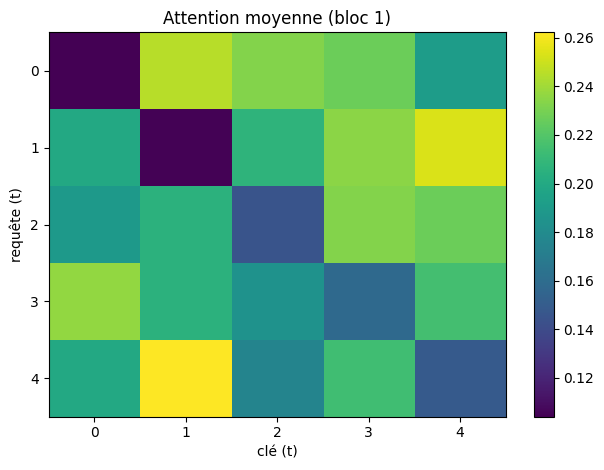

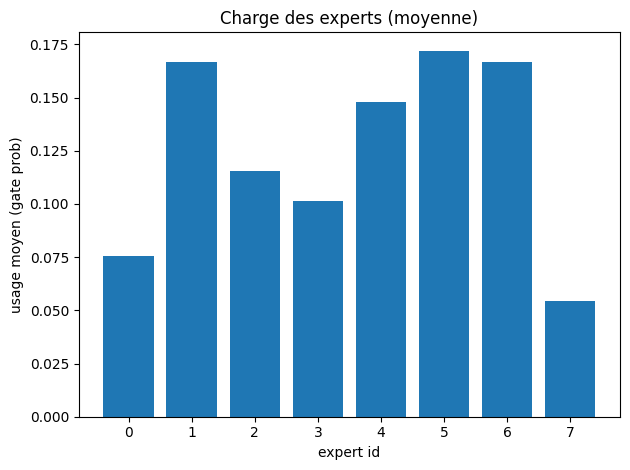

In [482]:

# Exemple: un batch test pour extraire attentions et l'utilisation moyenne des experts
with torch.no_grad():
    xb = torch.tensor(Xten[:64], dtype=torch.float32).to(DEVICE)
    z = model.proj(xb)
    attn_ws = []
    auxs = []
    h = z
    for blk in model.blocks:
        h2,w,aux = blk(h)
        attn_ws.append(w)   # [B, nhead, T, T]
        auxs.append(aux)    # [E]
        h = h2

# Heatmap attention moyenne premier bloc/tête
W = attn_ws[0].mean(dim=(0,1)).cpu().numpy()  # [T,T]
plt.figure()
plt.imshow(W, aspect="auto")
plt.colorbar(); plt.title("Attention moyenne (bloc 1)")
plt.xlabel("clé (t)"); plt.ylabel("requête (t)")
plt.tight_layout(); plt.show()

# Usage moyen des experts (moyenne blocs)
U = torch.stack([a for a in auxs]).mean(dim=0).cpu().numpy()
plt.figure()
plt.bar(range(len(U)), U)
plt.xlabel("expert id"); plt.ylabel("usage moyen (gate prob)")
plt.title("Charge des experts (moyenne)")
plt.tight_layout(); plt.show()


## Integrated Gradients (global & local)

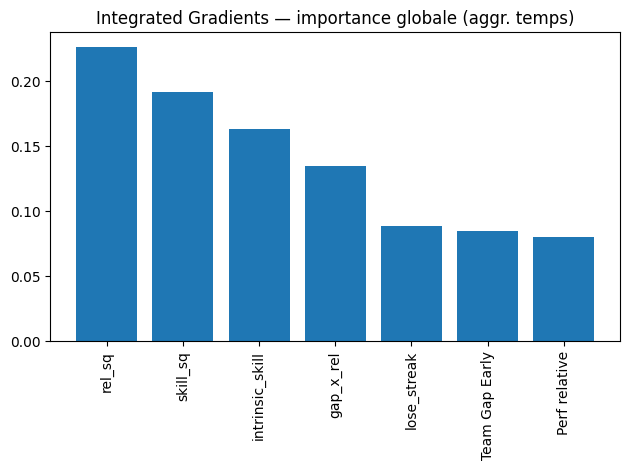

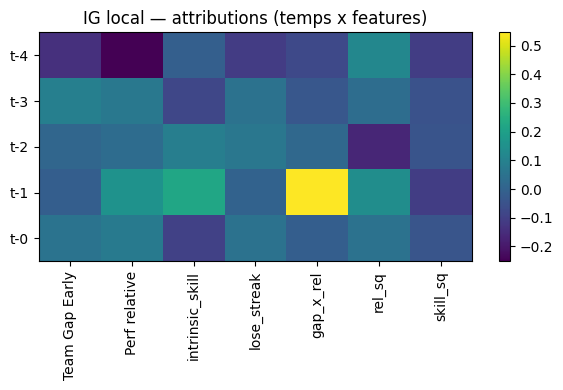

In [483]:

def integrated_gradients(model, x, steps=64, baseline=None, use_prob=False):
    """
    Calcule les Integrated Gradients pour un batch x: [B,T,D].
    - use_prob=False -> gradient du logit (recommandé si tu entraînes avec BCEWithLogitsLoss)
    - use_prob=True  -> gradient de la probabilité sigmoid(logit)
    Retour: attrs [B,T,D]
    """
    model.eval()  # désactive dropout, etc.
    
    # Tensor + device
    x = torch.as_tensor(x, dtype=torch.float32, device=DEVICE)
    if baseline is None:
        baseline = torch.zeros_like(x)

    total = torch.zeros_like(x)

    for k in range(1, steps + 1):
        alpha = float(k) / steps
        xk = baseline + alpha * (x - baseline)   # pas leaf -> on évite .grad
        xk.requires_grad_(True)                  # on s'assure que l'autograd suit xk

        logit, *_ = model(xk)                    # [B]
        out = torch.sigmoid(logit) if use_prob else logit

        # grad wrt xk (scalaire -> on somme les sorties pour avoir un scalaire)
        grads = torch.autograd.grad(outputs=out.sum(), inputs=xk, retain_graph=False)[0]
        total = total + grads

        # (optionnel) pour être clean :
        model.zero_grad(set_to_none=True)

    attrs = (x - baseline) * total / steps
    return attrs.detach().cpu().numpy()


# Global importance = moyenne des |attributions| agrégées sur (temps, batch)
idx = np.random.RandomState(0).choice(len(Xten), size=min(128,len(Xten)), replace=False)
A = integrated_gradients(model, Xten[idx], steps=64)   # [B,T,D]
G = np.mean(np.abs(A), axis=(0,1))                     # [D]
order = np.argsort(-G)
plt.figure()
plt.bar(range(len(G)), G[order])
plt.xticks(range(len(G)), np.array(FEATS)[order], rotation=90)
plt.title("Integrated Gradients — importance globale (aggr. temps)")
plt.tight_layout(); plt.show()

# Local (premier item test) — heatmap temps x features
L = integrated_gradients(model, Xten[0:1], steps=128)[0]  # [T,D]
plt.figure(figsize=(6,4))
plt.imshow(L, aspect="auto")
plt.xticks(range(len(FEATS)), FEATS, rotation=90)
plt.yticks(range(L.shape[0]), [f"t-{L.shape[0]-1-i}" for i in range(L.shape[0])])
plt.colorbar(); plt.title("IG local — attributions (temps x features)")
plt.tight_layout(); plt.show()


## LIME (local) & SHAP Kernel (global) — optionnels

In [484]:
def scale_flat_2d(X2D):
    """X2D: (N,D). Applique les 'scalers' colonne par colonne correctement (2D attendu)."""
    X = np.asarray(X2D, dtype=np.float32).copy()
    for j, sc in enumerate(scalers):
        X[:, j] = sc.transform(X[:, j].reshape(-1, 1)).ravel()
    return X

def to_seq_from_flat(X2D):
    """Répète chaque vecteur (N,D) sur WIN pas de temps -> (N,WIN,D)."""
    X = scale_flat_2d(X2D)
    return np.repeat(X[:, None, :], WIN, axis=1)

@torch.no_grad()
def logits_on_seq(Xseq):
    """Xseq: numpy (B,T,D). Retourne logits (B,)."""
    x = torch.from_numpy(Xseq.astype(np.float32)).to(DEVICE)
    logit, *_ = model(x)
    return logit.detach().cpu().numpy()

def logits_on_flat(X2D):
    """Interface modèle tabulaire 2D -> logits, en passant par la séquence."""
    Xseq = to_seq_from_flat(X2D)
    return logits_on_seq(Xseq)

def proba_on_flat_2cols(X2D):
    """Retourne proba classe 0/1 au format (N,2) pour LIME."""
    z = logits_on_flat(X2D)
    try:
        p = 1 / (1 + np.exp(-(a * z + b)))  # calibré si tu as a,b
    except NameError:
        p = 1 / (1 + np.exp(-z))            # sinon sigmoid
    return np.c_[1 - p, p]

def proba1_on_flat(X2D):
    """Retourne proba classe 1 au format (N,) pour SHAP."""
    return proba_on_flat_2cols(X2D)[:, 1]


In [485]:

def predict_proba_df(Xdf):
    X = Xdf[FEATS].values.astype(np.float32)
    # normaliser avec nos scalers (ATTN: reshape 2D)
    for j, sc in enumerate(scalers):
        X[:, j] = sc.transform(X[:, j].reshape(-1, 1)).ravel()
    # créer séquences en répliquant la ligne
    Xseq = np.repeat(X[np.newaxis, :], WIN, axis=0).transpose(1,0,2)  # [N,T,D]
    p = 1/(1+np.exp(-(a*logits_on(Xseq) + b)))
    return np.vstack([1-p, p]).T


# LIME
try:
    from lime.lime_tabular import LimeTabularExplainer

    # Base tabulaire (2D) sur tes features
    base = df[FEATS].fillna(0.0).astype(np.float32)

    explainer = LimeTabularExplainer(
        training_data=base.values,
        feature_names=FEATS,
        class_names=["lose","win"],
        mode="classification",
        discretize_continuous=True
    )

    i = 0  # exemple à expliquer
    x0 = base.iloc[i].values.astype(np.float32)

    # IMPORTANT: passer une fonction qui prend (N,D) et renvoie (N,2)
    exp = explainer.explain_instance(
        data_row=x0,
        predict_fn=proba_on_flat_2cols,
        num_features=min(10, len(FEATS)),
        top_labels=1
    )

    print("LIME (sample", i, ") – top contributions:")
    for name, val in exp.as_list(label=1):
        print(f"{name:20s} {val:+.4f}")

except Exception as e:
    print("LIME indisponible:", e)

# SHAP Kernel
try:
    import shap
    # Background (2D)
    bg_idx = np.random.RandomState(0).choice(len(base), size=min(100, len(base)), replace=False)
    bg = base.iloc[bg_idx].values.astype(np.float32)

    # f(x) doit accepter (N,D) et renvoyer (N,) => proba classe 1
    f_shap = proba1_on_flat

    expl = shap.KernelExplainer(f_shap, bg)
    x1 = x0.reshape(1, -1)
    sv = expl.shap_values(x1, nsamples=200)  # (1,D)

    print("SHAP (sample", i, ") – top contributions:")
    pairs = list(zip(FEATS, sv[0]))
    for name, val in sorted(pairs, key=lambda t: -abs(t[1]))[:10]:
        print(f"{name:20s} {val:+.4f}")

except Exception as e:
    print("SHAP indisponible:", e)


LIME (sample 0 ) – top contributions:
skill_sq <= 0.00     +0.0314
Perf relative <= -2.00 +0.0054
-1.00 < Team Gap Early <= 1.00 +0.0049
lose_streak <= 0.00  -0.0033
-1.00 < intrinsic_skill <= 0.00 -0.0032
-1.00 < gap_x_rel <= 1.00 +0.0010
1.00 < rel_sq <= 4.00 +0.0004


100%|██████████| 1/1 [00:05<00:00,  5.81s/it]

SHAP (sample 0 ) – top contributions:
rel_sq               -0.0151
Perf relative        -0.0136
intrinsic_skill      -0.0129
gap_x_rel            -0.0117
skill_sq             +0.0090
Team Gap Early       -0.0055
lose_streak          -0.0052


## PDP & ICE (dernière étape temporelle)

Text(0, 0.5, 'P(win)')

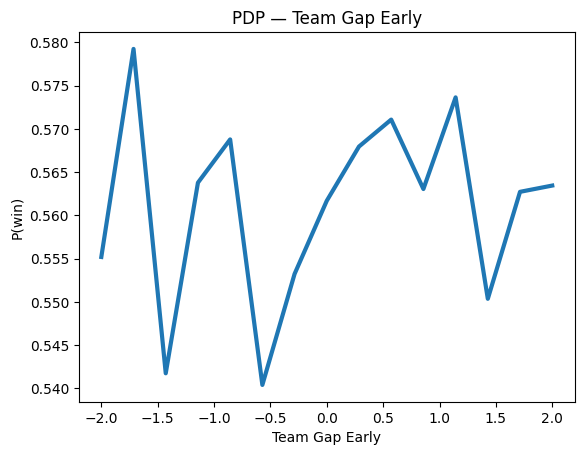

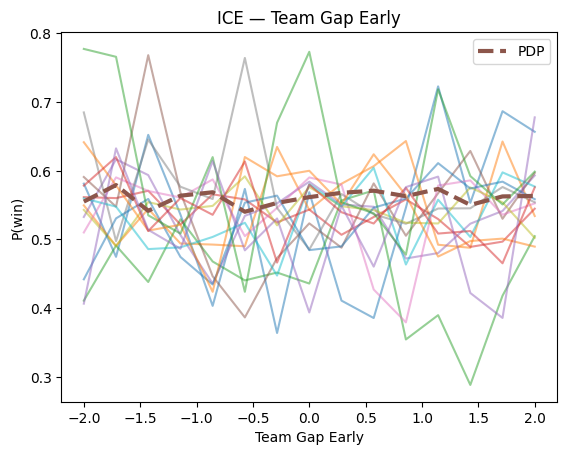

In [486]:

def pdp_1d(base_df, feat_name, grid_vals):
    """PDP 1D sur une feature en gardant les autres fixes à base_df (2D), 
       et en répétant sur le temps (WIN). Retourne proba moyenne par grid."""
    Xtmp = base_df.copy()
    out = []
    for v in grid_vals:
        Xtmp[feat_name] = v
        X = Xtmp[FEATS].values.astype(np.float32)
        # scaling par colonne (2D attendu)
        for j, sc in enumerate(scalers):
            X[:, j] = sc.transform(X[:, j].reshape(-1, 1)).ravel()
        # répéter sur le temps
        Xseq = np.repeat(X[:, None, :], WIN, axis=1)
        # proba calibrée si dispo
        z = logits_on_seq(Xseq)
        try:
            p = 1 / (1 + np.exp(-(a * z + b)))
        except NameError:
            p = 1 / (1 + np.exp(-z))
        out.append(p.mean())
    return np.array(out)

def ice_1d(base_df, feat_name, grid_vals, n_curves=20, seed=0):
    """ICE 1D: on trace n_curves lignes (échantillons) vs grid."""
    rng = np.random.RandomState(seed)
    idx = rng.choice(len(base_df), size=min(n_curves, len(base_df)), replace=False)
    curves = []
    for i in idx:
        row = base_df.iloc[[i]].copy()    # DataFrame (1,D)
        vals = []
        for v in grid_vals:
            row[feat_name] = v
            X = row[FEATS].values.astype(np.float32)  # (1,D)
            for j, sc in enumerate(scalers):
                X[:, j] = sc.transform(X[:, j].reshape(-1, 1)).ravel()
            Xseq = np.repeat(X[:, None, :], WIN, axis=1)
            z = logits_on_seq(Xseq)
            try:
                p = 1 / (1 + np.exp(-(a * z + b)))
            except NameError:
                p = 1 / (1 + np.exp(-z))
            vals.append(float(p[0]))
        curves.append(vals)
    return np.array(curves)  # (n_curves, len(grid_vals))


f = FEATS[0]  # feature étudiée
q = np.quantile(base[f], [0.05, 0.25, 0.5, 0.75, 0.95])
grid = np.linspace(q[0], q[-1], 15)

P = pdp_1d(base, f, grid)
C = ice_1d(base, f, grid, n_curves=15)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(grid, P, lw=3); plt.title(f"PDP — {f}")
plt.xlabel(f); plt.ylabel("P(win)")

plt.figure()
for k in range(C.shape[0]):
    plt.plot(grid, C[k], alpha=0.5)
plt.plot(grid, P, lw=3, linestyle="--", label="PDP")
plt.legend(); plt.title(f"ICE — {f}")
plt.xlabel(f); plt.ylabel("P(win)")



## Prédictions historiques vs modèle + 20 prédictions futures exportées

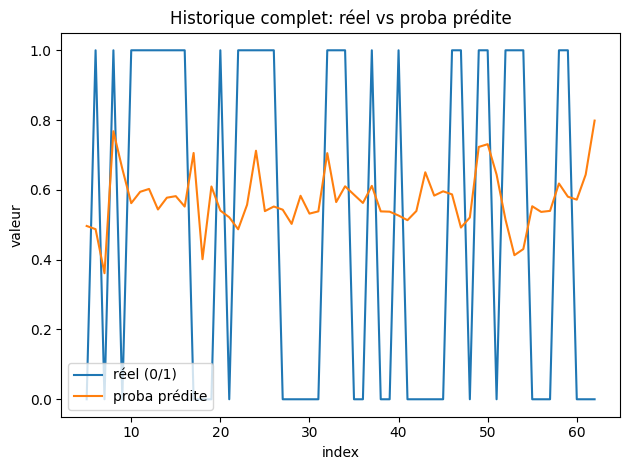

Écrit: future_predictions_transformer_moe_deterministic.csv


,step,pred_win_proba,gap_source,Team Gap Early,Perf relative,intrinsic_skill,lose_streak,gap_x_rel,rel_sq,skill_sq
0,1,63.38,Pred_TeamGapEarly_Next,2.0,0.0,0.800000,0.0,0.0,0.0,0.640000
1,2,46.89,persist,2.0,0.0,0.640000,0.0,0.0,0.0,0.409600
2,3,59.70,persist,2.0,0.0,0.512000,0.0,0.0,0.0,0.262144
3,4,77.22,persist,2.0,0.0,0.409600,0.0,0.0,0.0,0.167772
4,5,70.05,persist,2.0,0.0,0.327680,0.0,0.0,0.0,0.107374
5,6,66.31,persist,2.0,0.0,0.262144,0.0,0.0,0.0,0.068719
6,7,65.49,persist,2.0,0.0,0.209715,0.0,0.0,0.0,0.043980
7,8,58.68,persist,2.0,0.0,0.167772,0.0,0.0,0.0,0.028147
8,9,69.61,persist,2.0,0.0,0.134218,0.0,0.0,0.0,0.018014
9,10,61.23,persist,2.0,0.0,0.107374,0.0,0.0,0.0,0.011529


In [487]:
# --- (1) parse le Pred_TeamGapEarly_Next si présent (virer la virgule décimale FR) ---
PRED_GAP_COL = None
for c in df.columns:
    if "pred_teamgap" in c.lower() or "pred_teamgapearly_next" in c.lower():
        PRED_GAP_COL = c
        break

if PRED_GAP_COL is not None:
    df[PRED_GAP_COL] = pd.to_numeric(
        df[PRED_GAP_COL].astype(str).str.replace(",", ".", regex=False),
        errors="coerce"
    )

# --- (2) helpers ---
@torch.no_grad()
def _proba_from_window(win_feats_2d):
    """
    win_feats_2d: DataFrame/array shape (WIN, len(FEATS)) -> proba calibrée (float)
    """
    Xseq = np.asarray(win_feats_2d, dtype=np.float32).copy()  # (WIN, F)
    # scale 3D: appliquer scaler feature par feature
    for j, sc in enumerate(scalers):
        Xseq[:, j] = sc.transform(Xseq[:, j].reshape(-1,1)).ravel()
    Xseq = Xseq[None, ...]  # (1, WIN, F)
    logit, *_ = model(torch.from_numpy(Xseq).to(DEVICE))
    z = float(logit.item())
    try:
        return 1.0 / (1.0 + np.exp(-(a*z + b)))
    except NameError:
        return 1.0 / (1.0 + np.exp(-z))

def _next_row_from_prev(prev_row, gap_next, alpha_skill=0.2):
    """
    Construit la prochaine ligne de features à partir de la dernière observée (prev_row)
    en injectant gap_next. Perf relative est persistée (tu peux changer la règle facilement).
    """
    rel_next   = float(prev_row[rel_col])                   # persistance
    skill_prev = float(prev_row["intrinsic_skill"])
    skill_next = (1.0 - alpha_skill) * skill_prev + alpha_skill * rel_next  # EMA

    lose_prev  = float(prev_row["lose_streak"])
    lose_next  = lose_prev + 1.0 if gap_next < 0.0 else 0.0

    row = {
        gap_col:           float(np.clip(gap_next, -2, 2)),
        rel_col:           rel_next,
        "intrinsic_skill": skill_next,
        "lose_streak":     lose_next,
        "gap_x_rel":       float(gap_next * rel_next),
        "rel_sq":          float(rel_next**2),
        "skill_sq":        float(skill_next**2),
    }
    return pd.Series(row)[FEATS]

def simulate_next_k(df_full, k=20, gap_forecast_mode="persist"):
    """
    Simule k prochaines games SANS hasard :
      - s=1 : si Pred_TeamGapEarly_Next (col) dispo sur la DERNIÈRE ligne, on l'utilise
      - s>1 : on fait selon gap_forecast_mode:
          "persist"      -> on persiste le dernier gap (déterministe)
          "mean_revert"  -> reversion vers 0 (déterministe)
    Retourne un DataFrame avec les features simulées + proba à chaque pas.
    """
    assert len(df_full) >= WIN, "Pas assez d'historique pour une fenêtre WIN."

    # fenêtre initiale (les WIN dernières lignes) restreinte aux FEATS (déjà nettoyées)
    win = df_full[FEATS].tail(WIN).copy().reset_index(drop=True)

    # prochaine valeur de gap (s=1)
    last_row = df_full.iloc[-1]
    if (PRED_GAP_COL is not None) and np.isfinite(last_row.get(PRED_GAP_COL, np.nan)):
        gap_next_1 = float(last_row[PRED_GAP_COL])
    else:
        gap_next_1 = float(last_row[gap_col])  # persistance

    out_rows = []
    prev_gap = float(win.iloc[-1][gap_col])

    for step in range(1, k+1):
        if step == 1:
            gap_next = gap_next_1
        else:
            if gap_forecast_mode == "persist":
                gap_next = prev_gap
            elif gap_forecast_mode == "mean_revert":
                # petite reversion déterministe vers 0 : gap_{t+1} = 0.7*gapt
                gap_next = 0.7 * prev_gap
            else:
                gap_next = prev_gap  # fallback

        # construire la prochaine ligne de features
        new_row = _next_row_from_prev(win.iloc[-1], gap_next)
        # faire glisser la fenêtre (DROP 1 + ADD 1)
        win = pd.concat([win.iloc[1:, :], new_row.to_frame().T], ignore_index=True)

        # proba du modèle sur cette nouvelle fenêtre
        p = _proba_from_window(win.values)

        # mémoriser (pour export)
        out = dict(step=step, pred_win_proba=round(100*p, 2))
        for f in FEATS:
            out[f] = float(win.iloc[-1][f])
        out["gap_source"] = (
            "Pred_TeamGapEarly_Next" if (step==1 and PRED_GAP_COL is not None) else gap_forecast_mode
        )
        out_rows.append(out)

        prev_gap = float(win.iloc[-1][gap_col])

    scen = pd.DataFrame(out_rows)
    # Optionnel : ordonner les colonnes
    cols = ["step", "pred_win_proba", "gap_source"] + FEATS
    scen = scen[cols]
    return scen

# === Utilisation ===
df_all = df[[label_col] + FEATS + ([PRED_GAP_COL] if PRED_GAP_COL else [])].copy()

# Historique (inchangé)
idxs, reals, probs = roll_predict(df_all)
plt.figure()
plt.plot(idxs, reals, label="réel (0/1)")
plt.plot(idxs, probs, label="proba prédite")
plt.xlabel("index"); plt.ylabel("valeur"); plt.title("Historique complet: réel vs proba prédite")
plt.legend(); plt.tight_layout(); plt.show()

# Futures déterministes
scen = simulate_next_k(df_all, k=20, gap_forecast_mode="persist")  # ou "mean_revert"
scen_path = "future_predictions_transformer_moe_deterministic.csv"
scen.to_csv(scen_path, index=False)
print("Écrit:", scen_path)
display(scen.head(20))
